In [1]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI


/Users/jaganpradhan/Desktop/level_3/lang-graph/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1
/Users/jaganpradhan/Desktop/level_3/lang-graph/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
import os

# Load .env to get the Hugging Face token
load_dotenv()
hf_token = os.getenv("HUGGINGFACEHUB_API_TOKEN")

if not hf_token:
    raise ValueError("HUGGINGFACEHUB_API_TOKEN not found! Check your .env file.")

# Initialize LLM with a supported model (deployed for Inference API)
llm = HuggingFaceEndpoint(
    repo_id="HuggingFaceTB/SmolLM3-3B",  # Supported for chat_completion & text-generation
    huggingfacehub_api_token=hf_token,
    task="text-generation",  # Or "conversational" if available
    temperature=0.7,
    max_new_tokens=150
)

# Wrap with chat interface (handles templating automatically)
chat = ChatHuggingFace(llm=llm)

In [5]:
class GDState(TypedDict):
    topic: str
    technique: str
    iteration: int
    max_iterations: int
    score: float

    prep_points: List[str]
    news_points: List[str]
    analytical_points: List[str]
    gd_phrases: Dict[str, List[str]]


In [6]:
def has_min_words(text: str, minimum: int = 20) -> bool:
    return len(text.split()) >= minimum


In [7]:
def llm_generate_points(
    prompt: str,
    min_items: int,
    min_words: int = 20,
    max_retries: int = 5
) -> List[str]:

    last_points = []

    for _ in range(max_retries):
        response = chat.invoke(prompt)
        points = [
            p.strip("-•0123456789. ").strip()
            for p in response.content.split("\n")
            if p.strip()
        ]

        last_points = points

        if len(points) >= min_items and all(has_min_words(p, min_words) for p in points):
            return points[:min_items]

    # fallback expansion (never crash the graph)
    expand_prompt = f"""
    Expand each of the following points so that EACH has at least {min_words} words.
    Do not shorten ideas. Add explanation where needed.

    Points:
    {last_points}
    """

    response = chat.invoke(expand_prompt)

    expanded = [
        p.strip("-•0123456789. ").strip()
        for p in response.content.split("\n")
        if p.strip()
    ]

    return expanded[:min_items]


In [8]:
def select_technique(state: GDState) -> GDState:
    # Simple deterministic choice (can be LLM-based later)
    state["technique"] = "POPBEAS"
    return state


In [9]:
def node_a_prep_points(state: GDState) -> dict:
    prompt = f"""
    Generate EXACTLY 3 preparation points using the {state['technique']} technique
    for the topic "{state['topic']}".

    Rules:
    - Each point must be a single paragraph
    - Minimum 20 words per point
    - Written for Group Discussion preparation
    - Numbered format
    """

    prep_points = llm_generate_points(
        prompt=prompt,
        min_items=3,
        min_words=20
    )

    return {
        "prep_points": prep_points
    }


In [10]:
def node_b_news(state: GDState) -> dict:
    prompt = f"""
    Generate EXACTLY 5 recent, real-world news-based points related to:
    "{state['topic']}".

    Rules:
    - Each point must have at least 20 words
    - Focus on policies, companies, regulations, or global trends
    - Suitable for Group Discussion
    """

    news_points = llm_generate_points(
        prompt=prompt,
        min_items=5,
        min_words=20
    )

    return {
        "news_points": news_points
    }


In [11]:
def node_c_analytics(state: GDState) -> dict:
    prompt = f"""
    Generate EXACTLY 5 analytical, data-driven points for the topic:
    "{state['topic']}".

    Rules:
    - Each point must include numbers, percentages, savings, or measurable impact
    - Minimum 20 words per point
    - Use realistic industry or company-level examples
    """

    analytical_points = llm_generate_points(
        prompt=prompt,
        min_items=5,
        min_words=20
    )

    return {
        "analytical_points": analytical_points
    }


In [23]:
import re

def extract_score(text: str) -> float:
    match = re.search(r"\b(10(?:\.0)?|[0-9](?:\.\d+)?)\b", text)
    if match:
        return float(match.group(1))
    return 7.0  # safe fallback
def evaluate_content(state: GDState) -> GDState:
    combined = (
        state["prep_points"]
        + state["news_points"]
        + state["analytical_points"]
    )

    prompt = f"""
    Evaluate the following Group Discussion content on a scale of 0 to 10.

    Criteria:
    - Relevance
    - Depth
    - Analytical strength
    - GD usefulness
    - Clarity

    Content:
    {combined}
    """

    response = chat.invoke(prompt)

    score = extract_score(response.content)  # ✅ FIX HERE

    state["score"] = score
    state["iteration"] += 1
    return state


In [13]:
def should_continue(state: GDState) -> str:
    if state["score"] >= 8 or state["iteration"] >= state["max_iterations"]:
        return "stop"
    return "continue"


In [14]:
def gd_phrase_node(state: GDState) -> GDState:
    state["gd_phrases"] = {
        "alternative_perspective": [
            "Let’s consider an alternative perspective.",
            "I’d like to offer a different point of view.",
            "Another way to look at this is…",
            "There’s also a contrasting perspective we could consider.",
            "May I add a different angle to this discussion?"
        ],
        "respectful_disagreement": [
            "I respectfully disagree with that point.",
            "I see your point, but I have a slightly different opinion.",
            "I understand where you’re coming from; however…",
            "That’s a valid argument, though I see it differently.",
            "I’d like to disagree, but with respect to your viewpoint."
        ]
    }
    return state


In [24]:
graph = StateGraph(GDState)

graph.add_node("select_technique", select_technique)
graph.add_node("prep", node_a_prep_points)
graph.add_node("news", node_b_news)
graph.add_node("analytics", node_c_analytics)
graph.add_node("evaluate", evaluate_content)
graph.add_node("gd_phrases", gd_phrase_node)

graph.set_entry_point("select_technique")

# fan-out (parallel)
graph.add_edge("select_technique", "prep")
graph.add_edge("select_technique", "news")
graph.add_edge("select_technique", "analytics")

# fan-in (merge)
graph.add_edge("prep", "evaluate")
graph.add_edge("news", "evaluate")
graph.add_edge("analytics", "evaluate")

graph.add_conditional_edges(
    "evaluate",
    should_continue,
    {
        "continue": "prep",
        "stop": "gd_phrases"
    }
)

graph.add_edge("gd_phrases", END)

app = graph.compile()


In [25]:
initial_state: GDState = {
    "topic": "Impact of Artificial Intelligence on Employment",
    "technique": "",
    "iteration": 0,
    "max_iterations": 3,
    "score": 0.0,
    "prep_points": [],
    "news_points": [],
    "analytical_points": [],
    "gd_phrases": {}
}

final_state = app.invoke(initial_state)


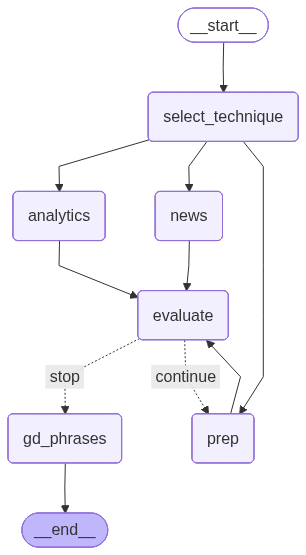

In [ ]:
app

In [26]:
final_state

{'topic': 'Impact of Artificial Intelligence on Employment',
 'technique': 'POPBEAS',
 'iteration': 3,
 'max_iterations': 3,
 'score': 7.0,
 'prep_points': ['<think>',
  'Okay, let\'s tackle this. The user wants me to expand each of the three points into at least 20 words without shortening any ideas. The original points are about the POPBEAS technique for the topic "Impact of Artificial Intelligence on Employment." First, I need to confirm what POPBEAS stands for. From the given text, the user mentioned it\'s an acronym, possibly from their training data. The letters are P, O, P, B, E, A, S. The user tried to break it down as Problem, Opposing View, Pro Argument, Brief Analysis, Example, Application, Summary. But they aren\'t entirely sure. The user might have a specific meaning in mind, so I need to stick'],
 'news_points': ['<think>',
  "Okay, so the user wants me to expand each of the given points about AI's impact on employment, making sure each has at least 20 words and adding ex